# Actividad 2 de la asignatura de Percepción Computacional. Trabajo grupal

Los integrantes del grupo que han participado en esta actividad son:

    1. Enrique Barreneche Ivorra
    2. Antonio Escacena Marchena
    3. Andrés Sánchez Sánchez
    4. Eduardo Sanz Valdeolivas

En esta actividad se van a utilizar filtros espaciales y morfológicos con el objetivo de dar una apariencia de dibujo a fotos.

Para ello se seguirá el siguiente esquema de proceder:
   1. Umbralizar una foto con el objetivo de destacar ciertos bordes en la foto, que serán usados para dar apariencia de dibujo
   2. Reducir la paleta de colores de una foto original, ya que las fotos constan con más colores que un dibujo
   3. Realizar un desenfoque para hacer que la foto sea menos realista
   4. Realizar un repujado para darle relieve a los bordes y dar más sensación de imagen artificial
   5. Incorporar los bordes detectados en el paso 1 que unido al repujado de la foto, hará la foto más natural

In [1]:
#Se importan las librerías necesarias para realizar el ejercicio
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
#Se crea esta función para cargar las imagenes que se vayan a tratar
def read_file(filename):
    img = cv.imread(filename)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    return img
#Se crea esta función para mostrar por pantalla la imagen de manera rápida
#La n indica si queremos una imagen en escala de grises o en RGB
def imshow(im,n):
    if n==0:
        #Imagen normal
        plt.figure(figsize=(10,10))
        plt.imshow(im)
    else:
        #Imagen en escala de grises
        fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)
        ax.imshow(im, cmap='gray')

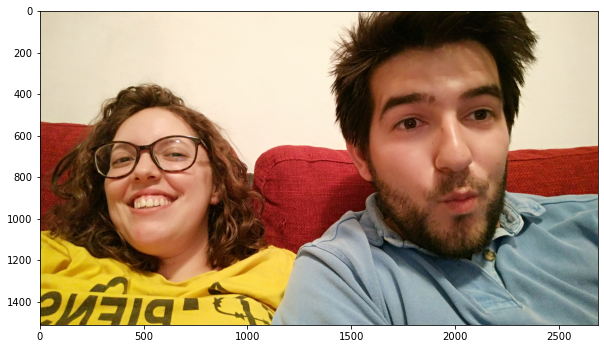

In [3]:
filename='px.jpg'
im=read_file(filename)
imshow(im,0)

## 1. Localizar Bordes

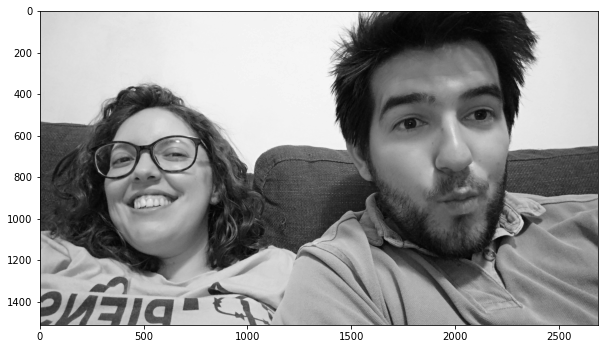

In [4]:
#Convertir la imagen en escala de grises
gris=cv.cvtColor(im.copy(),cv.COLOR_RGB2GRAY)
imshow(gris,1)

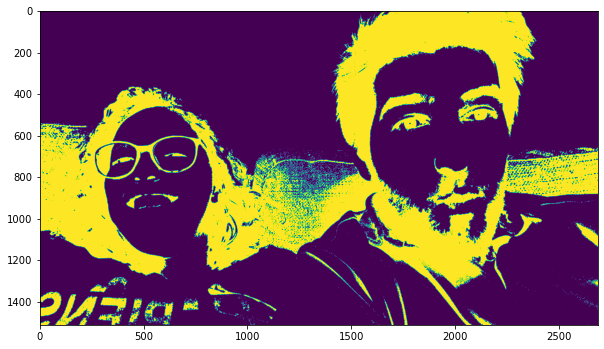

In [5]:
#Umbralizamos la imagen y binarizamos la misma aciendo que todo lo que este por encima de 80 sea 255 y por debajo 0
_,binaria=cv.threshold(gris,80,255,cv.THRESH_BINARY_INV)
imshow(binaria,0)

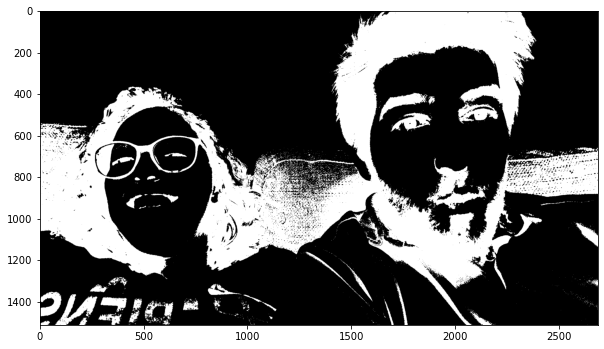

In [6]:
#Se representa en escala de grises
imshow(binaria,1)

In [7]:
#Se pretende eliminar el ruido impulsivo con una apertura y un cierre
kernel = np.ones((7,7),np.uint8)
apertura = cv.morphologyEx(binaria.copy(), cv.MORPH_OPEN, kernel)
cierre = cv.morphologyEx(apertura.copy(), cv.MORPH_CLOSE, kernel)

(-0.5, 2687.5, 1511.5, -0.5)

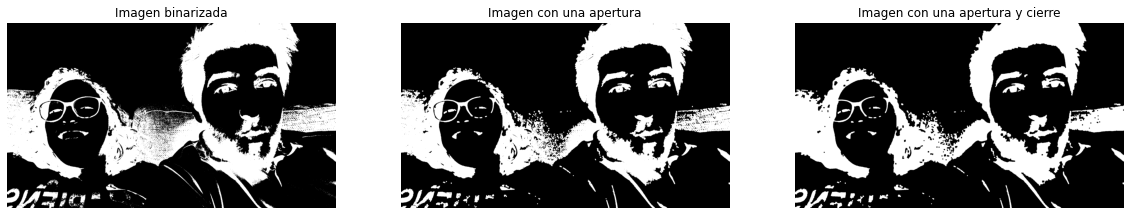

In [8]:
#Se mostrará la imagen binarizada, la apertura y la apertura y el cierre
fig, (ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(20,20),sharex=True,sharey=True)
ax1.imshow(binaria,cmap='gray')
ax2.imshow(apertura,cmap='gray')
ax3.imshow(cierre,cmap='gray')

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')
ax3.set_adjustable(adjustable='box')

ax1.set_title('Imagen binarizada')
ax1.axis('off')
ax2.set_title('Imagen con una apertura')
ax2.axis('off')
ax3.set_title('Imagen con una apertura y cierre')
ax3.axis('off')

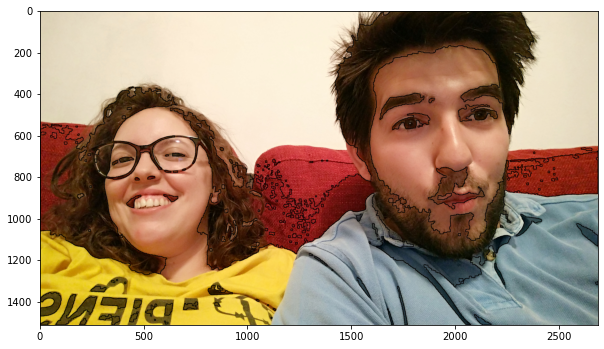

In [9]:
#Después de la apertura y cierre, se buscan los bordes y se ve como queda en la imagen original
contornos,_=cv.findContours(cierre,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
imagen=cv.drawContours(im.copy(),contornos,-1,(0,0,0),2)
imshow(imagen,0)

## 2. Reducir la paleta de colores

Redicir la paleta de colores consite en disminuir el número de colores de la foto, y se hace con el algortimo de kmeans que consiste en agrupar los colores mas próximos y reduciendo ese número.

A continuación, se explica esta función:

Definición de la función cv.kmeans

Input parameters

data: debe ser del tipo de datos np.float32 , y cada característica debe colocarse en una sola columna.

nclusters (K) : número de clústeres necesarios al final

criteria: es el criterio de terminación de la iteración. Cuando se satisface este criterio, la iteración del algoritmo se detiene. En realidad, debería ser una tupla de 3 parámetros. Son (type, max_iter, epsilon):

 a. tipo de criterio de terminación. Tiene 3 banderas de la siguiente manera:

     cv.TERM_CRITERIA_EPS: detiene la iteración del algoritmo si se alcanza la precisión especificada, épsilon.

     cv.TERM_CRITERIA_MAX_ITER: detiene el algoritmo después del número especificado de iteraciones, max_iter.

     cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER: detiene la iteración cuando se cumple algunas condiciones anteriores.
 b. max_iter - un número entero que especifica el número máximo de iteraciones.

 c. epsilon - Precisión requerida
attempts: marca para especificar el número de veces que se ejecuta el algoritmo utilizando diferentes etiquetas iniciales. El algoritmo devuelve las etiquetas que producen la mejor compacidad. Esta compacidad se devuelve como salida.

flags: esta bandera se utiliza para especificar cómo se toman los centros iniciales. Normalmente se utilizan dos banderas para esto: cv.KMEANS_PP_CENTERS y cv.KMEANS_RANDOM_CENTERS.

Output parameters

compactness : Es la suma de la distancia al cuadrado de cada punto a sus centros correspondientes.
labels : Esta es la matriz de etiquetas (igual que 'código' en el artículo anterior) donde cada elemento marcaba '0', '1' ..
centers : se trata de una serie de centros de agrupaciones.

In [10]:
def paleta_color(img, color):
    
    data = np.float32(img).reshape((-1, 3))
    
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.001)

    compactness, label, center = cv.kmeans(data, color, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    result = center[label.flatten()]
    result = result.reshape(img.shape)
    return result

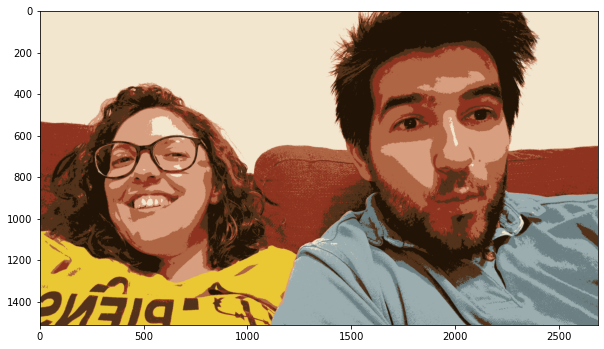

In [11]:
img = paleta_color(im.copy(), 9)
imshow(img,0)

## 3. Difuminar la imagen

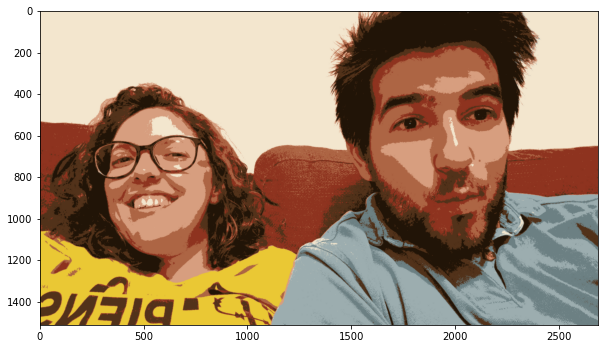

In [12]:
#Se usa un filtro de difuminar para suavizar la imagen ya tratada con la función de paleta_color
kernel=np.array([[1/16,2/16,1/16],[2/16,4/16,2/16],[1/16,2/16,1/16]])

dif0=signal.convolve2d(img.copy()[:,:,0],kernel,boundary='symm',mode='same')
dif1=signal.convolve2d(img.copy()[:,:,1],kernel,boundary='symm',mode='same')
dif2=signal.convolve2d(img.copy()[:,:,2],kernel,boundary='symm',mode='same')

dif=np.stack([dif0,dif1,dif2],axis=2).astype('uint8')
imshow(dif,0)

## 4. Hacer un repujado de la imagen

(-0.5, 2687.5, 1511.5, -0.5)

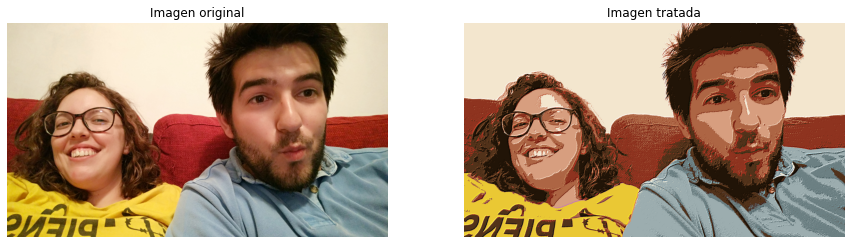

In [13]:
#Ahora se le da el filtro de repujado para dar relieve a los bordes
kernel=np.array([[-2,-1,0],[-1,1,1],[0,1,2]])

repujado0=signal.convolve2d(dif.copy()[:,:,0],kernel,boundary='symm',mode='same')
repujado1=signal.convolve2d(dif.copy()[:,:,1],kernel,boundary='symm',mode='same')
repujado2=signal.convolve2d(dif.copy()[:,:,2],kernel,boundary='symm',mode='same')

repujado=np.stack([repujado0,repujado1,repujado2],axis=2)
repujado[repujado>255]=255
repujado[repujado<0]=0

fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(im)
ax2.imshow(repujado)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

ax1.set_title('Imagen original')
ax1.axis('off')
ax2.set_title('Imagen tratada')
ax2.axis('off')

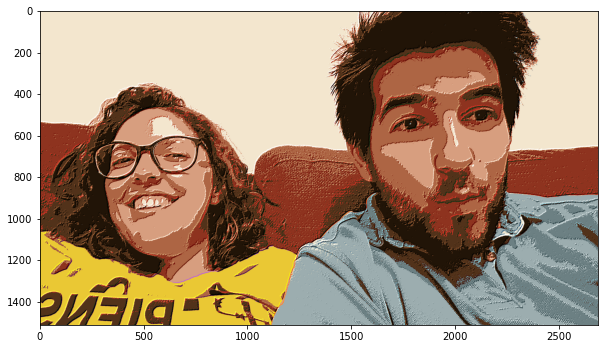

In [14]:
imshow(repujado,0)

## 5. Resaltar bordes de la foto definida

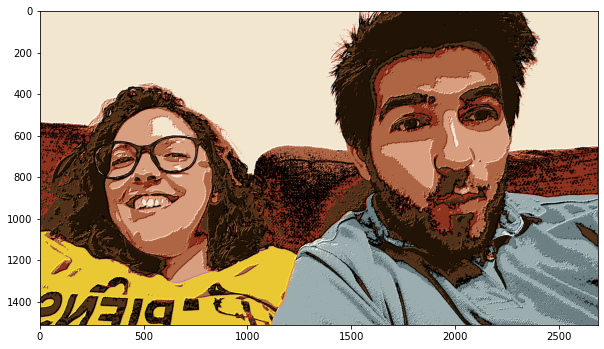

In [15]:
#Se le añade los bordes a la imagen para dar sensación de dibujo
contornos,_=cv.findContours(binaria.copy(),cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
imagen=cv.drawContours(repujado.copy(),contornos,-1,(0,0,0),2)
imshow(imagen,0)

(-0.5, 2687.5, 1511.5, -0.5)

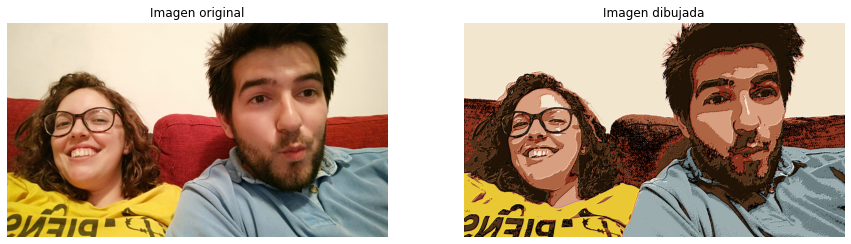

In [16]:
fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(15,15),sharex=True,sharey=True)

ax1.imshow(im)
ax2.imshow(imagen)

ax1.set_adjustable(adjustable='box')
ax2.set_adjustable(adjustable='box')

ax1.set_title('Imagen original')
ax1.axis('off')

ax2.set_title('Imagen dibujada')
ax2.axis('off')